This kernel is a mere copy from https://www.kaggle.com/tuckerarrants/openvaccine-gru-lstm, my only contribution is to show how much the scoring is affected by training only on "signal_to_noise" levels higher than 1.

In [ ]:
import warnings
warnings.filterwarnings('ignore')

#the basics
import pandas as pd, numpy as np
import math, json, gc, random, os, sys
from matplotlib import pyplot as plt
from tqdm import tqdm

#tensorflow deep learning basics
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.layers import LSTM


#for model evaluation
from sklearn.model_selection import train_test_split, KFold


print("set up complete!")

set up complete!


Sure, let me explain the code snippet you provided.

First, the `warnings` library is imported and its `filterwarnings` function is used to ignore warnings. This is done to suppress any warning messages that may be generated during the code execution.

Next, various Python libraries are imported including `pandas` and `numpy` for data manipulation, `math` for mathematical operations, `json` for working with JSON data, `gc` for garbage collection, `random` for generating random numbers, `os` for accessing the operating system functionalities, `sys` for system-specific parameters and functions, `matplotlib` for data visualization, and `tqdm` for progress bar visualization.

After that, the TensorFlow library is imported along with its add-ons library `tensorflow_addons`. `keras` is imported from TensorFlow for creating and training neural networks. `layers` is also imported from `tensorflow.keras` for creating layers in neural networks. `LSTM` is a specific type of layer used for sequence modeling.

Lastly, the `train_test_split` and `KFold` functions are imported from `sklearn.model_selection` library for splitting data into training and testing sets, and for performing k-fold cross-validation, respectively.

The last line simply prints a message indicating that the setup is complete.

Overall, this code sets up the necessary libraries and tools needed for deep learning with TensorFlow and other useful libraries.

# Competition Overview

**In this [new competition](https://www.kaggle.com/c/stanford-covid-vaccine/overview) we are helping to fight against the worldwide pandemic COVID-19. mRNA vaccines are the fastest vaccine candidates to treat COVID-19 but they currently facing several limitations. In particular, it is a challenge to design stable messenger RNA molecules. Typical vaccines are packaged in syringes and shipped under refrigeration around the world, but that is not possible for mRNA vaccines (currently).**

**Researches have noticed that RNA molecules tend to spontaneously degrade, which is highly problematic because a single cut can render mRNA vaccines useless. Not much is known about which part of the backbone of a particular RNA is most susceptible to being damaged.**

**Without this knowledge, the current mRNA vaccines are shopped under intense refrigeration and are unlikely to reach enough humans unless they can be stabilized. This is our task as Kagglers: we must create a model to predict the most likely degradation rates at each base of an RNA molecule.**

**We are given a subset of an Eterna dataset comprised of over 3000 RNA molecules and their degradation rates at each position. Our models are then tested on the new generation of RNA sequences that were just created by Eterna players for COVID-19 mRNA vaccines**

In [ ]:
#get comp data
train = pd.read_json('/kaggle/input/stanford-covid-vaccine/train.json', lines=True)
test = pd.read_json('/kaggle/input/stanford-covid-vaccine/test.json', lines=True)
sample_sub = pd.read_csv('/kaggle/input/stanford-covid-vaccine/sample_submission.csv')


print ("Data Load Complete")

Data Load Complete


# Brief EDA

In [ ]:
#sneak peak
print(train.shape)
if ~ train.isnull().values.any(): print('No missing values')
train.head()

(2400, 19)
No missing values


,index,id,sequence,structure,predicted_loop_type,signal_to_noise,SN_filter,seq_length,seq_scored,reactivity_error,deg_error_Mg_pH10,deg_error_pH10,deg_error_Mg_50C,deg_error_50C,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,0,id_001f94081,GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUA...,.....((((((.......)))).)).((.....((..((((((......,EEEEESSSSSSHHHHHHHSSSSBSSXSSIIIIISSIISSSSSSHHH...,6.894,1,107,68,"[0.1359, 0.20700000000000002, 0.1633, 0.1452, ...","[0.26130000000000003, 0.38420000000000004, 0.1...","[0.2631, 0.28600000000000003, 0.0964, 0.1574, ...","[0.1501, 0.275, 0.0947, 0.18660000000000002, 0...","[0.2167, 0.34750000000000003, 0.188, 0.2124, 0...","[0.3297, 1.5693000000000001, 1.1227, 0.8686, 0...","[0.7556, 2.983, 0.2526, 1.3789, 0.637600000000...","[2.3375, 3.5060000000000002, 0.3008, 1.0108, 0...","[0.35810000000000003, 2.9683, 0.2589, 1.4552, ...","[0.6382, 3.4773, 0.9988, 1.3228, 0.78770000000..."
1,1,id_0049f53ba,GGAAAAAGCGCGCGCGGUUAGCGCGCGCUUUUGCGCGCGCUGUACC...,.....(((((((((((((((((((((((....)))))))))).)))...,EEEEESSSSSSSSSSSSSSSSSSSSSSSHHHHSSSSSSSSSSBSSS...,0.193,0,107,68,"[2.8272, 2.8272, 2.8272, 4.7343, 2.5676, 2.567...","[73705.3985, 73705.3985, 73705.3985, 73705.398...","[10.1986, 9.2418, 5.0933, 5.0933, 5.0933, 5.09...","[16.6174, 13.868, 8.1968, 8.1968, 8.1968, 8.19...","[15.4857, 7.9596, 13.3957, 5.8777, 5.8777, 5.8...","[0.0, 0.0, 0.0, 2.2965, 0.0, 0.0, 0.0, 0.0, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.947, 4.4523, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.8511, 4.0426, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[7.6692, 0.0, 10.9561, 0.0, 0.0, 0.0, 0.0, 0.0..."
2,2,id_006f36f57,GGAAAGUGCUCAGAUAAGCUAAGCUCGAAUAGCAAUCGAAUAGAAU...,.....((((.((.....((((.(((.....)))..((((......)...,EEEEESSSSISSIIIIISSSSMSSSHHHHHSSSMMSSSSHHHHHHS...,8.800,1,107,68,"[0.0931, 0.13290000000000002, 0.11280000000000...","[0.1365, 0.2237, 0.1812, 0.1333, 0.1148, 0.160...","[0.17020000000000002, 0.178, 0.111, 0.091, 0.0...","[0.1033, 0.1464, 0.1126, 0.09620000000000001, ...","[0.14980000000000002, 0.1761, 0.1517, 0.116700...","[0.44820000000000004, 1.4822, 1.1819, 0.743400...","[0.2504, 1.4021, 0.9804, 0.49670000000000003, ...","[2.243, 2.9361, 1.0553, 0.721, 0.6396000000000...","[0.5163, 1.6823000000000001, 1.0426, 0.7902, 0...","[0.9501000000000001, 1.7974999999999999, 1.499..."
3,3,id_0082d463b,GGAAAAGCGCGCGCGCGCGCGCGAAAAAGCGCGCGCGCGCGCGCGC...,......((((((((((((((((......))))))))))))))))((...,EEEEEESSSSSSSSSSSSSSSSHHHHHHSSSSSSSSSSSSSSSSSS...,0.104,0,107,68,"[3.5229, 6.0748, 3.0374, 3.0374, 3.0374, 3.037...","[73705.3985, 73705.3985, 73705.3985, 73705.398...","[11.8007, 12.7566, 5.7733, 5.7733, 5.7733, 5.7...","[121286.7181, 121286.7182, 121286.7181, 121286...","[15.3995, 8.1124, 7.7824, 7.7824, 7.7824, 7.78...","[0.0, 2.2399, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","[0.0, -0.5083, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[3.4248, 6.8128, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, -0.8365, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[7.6692, -1.3223, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
4,4,id_0087940f4,GGAAAAUAUAUAAUAUAUUAUAUAAAUAUAUUAUAGAAGUAUAAUA...,.....(((((((.((((((((((((.(((((((((....)))))))...,EEEEESSSSSSSBSSSSSSSSSSSSBSSSSSSSSSHHHHSSSSSSS...,0.423,0,107,68,"[1.665, 2.1728, 2.0041, 1.2405, 0.620200000000...","[4.2139, 3.9637000000000002, 3.2467, 2.4716, 1...","[3.0942, 3.015, 2.1212, 2.0552, 0.881500000000...","[2.6717, 2.4818, 1.9919, 2.5484999999999998, 1...","[1.3285, 3.6173, 1.3057, 1.3021, 1.1507, 1.150...","[0.8267, 2.6577, 2.8481, 0.40090000000000003, ...","[2.1058, 3.138, 2.5437000000000003, 1.0932, 0....","[4.7366, 4.6243, 1.2068, 1.1538, 0.0, 0.0, 0.7...","[2.2052, 1.7947000000000002, 0.7457, 3.1233, 0...","[0.0, 5.1198, -0.3551, -0.3518, 0.0, 0.0, 0.0,..."


In [ ]:

def add_list(test_list1, test_list2):
    res_list = [] 
    for i in range(0, len(test_list1)): 
        res_list.append(test_list1[i] + test_list2[i])
    return res_list

def subtract_list(test_list1, test_list2):
    res_list = [] 
    for i in range(0, len(test_list1)): 
        res_list.append(test_list1[i] - test_list2[i])
    return res_list

In [ ]:
#Create additional target features

#adding the errors - this will overpredict the target variables
train['reactivity_over'] = train.apply(lambda x: add_list(x.reactivity,x.reactivity_error), axis=1)
train['deg_Mg_pH10_over'] = train.apply(lambda x: add_list(x.deg_Mg_pH10,x.deg_error_Mg_pH10), axis=1)
train['deg_pH10_over'] = train.apply(lambda x: add_list(x.deg_pH10,x.deg_error_pH10), axis=1)
train['deg_Mg_50C_over'] = train.apply(lambda x: add_list(x.deg_Mg_50C,x.deg_error_Mg_50C), axis=1)
train['deg_50C_over'] = train.apply(lambda x: add_list(x.deg_50C,x.deg_error_50C), axis=1)

#subtracting the errors - this will underpredict the target variables
train['reactivity_under'] = train.apply(lambda x: subtract_list(x.reactivity,x.reactivity_error), axis=1)
train['deg_Mg_pH10_under'] = train.apply(lambda x: subtract_list(x.deg_Mg_pH10,x.deg_error_Mg_pH10), axis=1)
train['deg_pH10_under'] = train.apply(lambda x: subtract_list(x.deg_pH10,x.deg_error_pH10), axis=1)
train['deg_Mg_50C_under'] = train.apply(lambda x: subtract_list(x.deg_Mg_50C,x.deg_error_Mg_50C), axis=1)
train['deg_50C_under'] = train.apply(lambda x: subtract_list(x.deg_50C,x.deg_error_50C), axis=1)

print ("Additional target variables created!")

Additional target variables created!


In [ ]:
train.head()

,index,id,sequence,structure,predicted_loop_type,signal_to_noise,SN_filter,seq_length,seq_scored,reactivity_error,...,reactivity_over,deg_Mg_pH10_over,deg_pH10_over,deg_Mg_50C_over,deg_50C_over,reactivity_under,deg_Mg_pH10_under,deg_pH10_under,deg_Mg_50C_under,deg_50C_under
0,0,id_001f94081,GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUA...,.....((((((.......)))).)).((.....((..((((((......,EEEEESSSSSSHHHHHHHSSSSBSSXSSIIIIISSIISSSSSSHHH...,6.894,1,107,68,"[0.1359, 0.20700000000000002, 0.1633, 0.1452, ...",...,"[0.4656, 1.7763000000000002, 1.286, 1.0138, 0....","[1.0169000000000001, 3.3672, 0.389800000000000...","[2.6006, 3.7920000000000003, 0.3972, 1.1682, 0...","[0.5082, 3.2433, 0.3536, 1.6418000000000001, 0...","[0.8549, 3.8248, 1.1868, 1.5352, 0.95800000000...","[0.1938, 1.3623, 0.9594, 0.7234, 0.5903, 0.333...","[0.4943, 2.5988, 0.11539999999999997, 1.1258, ...","[2.0744, 3.22, 0.20440000000000003, 0.85339999...","[0.20800000000000002, 2.6933000000000002, 0.16...","[0.4215, 3.1298, 0.8108, 1.1104, 0.61740000000..."
1,1,id_0049f53ba,GGAAAAAGCGCGCGCGGUUAGCGCGCGCUUUUGCGCGCGCUGUACC...,.....(((((((((((((((((((((((....)))))))))).)))...,EEEEESSSSSSSSSSSSSSSSSSSSSSSHHHHSSSSSSSSSSBSSS...,0.193,0,107,68,"[2.8272, 2.8272, 2.8272, 4.7343, 2.5676, 2.567...",...,"[2.8272, 2.8272, 2.8272, 7.0308, 2.5676, 2.567...","[73705.3985, 73705.3985, 73705.3985, 73705.398...","[15.145600000000002, 13.694099999999999, 5.093...","[21.4685, 17.910600000000002, 8.1968, 8.1968, ...","[23.154899999999998, 7.9596, 24.35179999999999...","[-2.8272, -2.8272, -2.8272, -2.4378, -2.5676, ...","[-73705.3985, -73705.3985, -73705.3985, -73705...","[-5.251600000000001, -4.789499999999999, -5.09...","[-11.766300000000001, -9.8254, -8.1968, -8.196...","[-7.8165, -7.9596, -2.4396000000000004, -5.877..."
2,2,id_006f36f57,GGAAAGUGCUCAGAUAAGCUAAGCUCGAAUAGCAAUCGAAUAGAAU...,.....((((.((.....((((.(((.....)))..((((......)...,EEEEESSSSISSIIIIISSSSMSSSHHHHHSSSMMSSSSHHHHHHS...,8.800,1,107,68,"[0.0931, 0.13290000000000002, 0.11280000000000...",...,"[0.5413, 1.6151, 1.2947, 0.8325, 0.7992, 0.733...","[0.3869, 1.6258, 1.1616, 0.63, 0.4801, 1.0575,...","[2.4132, 3.1141, 1.1663, 0.8119999999999999, 0...","[0.6195999999999999, 1.8287000000000002, 1.155...","[1.0999, 1.9735999999999998, 1.6508, 0.9853000...","[0.3551, 1.3493, 1.0691, 0.6543000000000001, 0...","[0.1139, 1.1784, 0.7992, 0.36340000000000006, ...","[2.0728, 2.7581, 0.9442999999999999, 0.63, 0.5...","[0.413, 1.5359, 0.9299999999999999, 0.694, 0.6...","[0.8003, 1.6214, 1.3474000000000002, 0.7519, 0..."
3,3,id_0082d463b,GGAAAAGCGCGCGCGCGCGCGCGAAAAAGCGCGCGCGCGCGCGCGC...,......((((((((((((((((......))))))))))))))))((...,EEEEEESSSSSSSSSSSSSSSSHHHHHHSSSSSSSSSSSSSSSSSS...,0.104,0,107,68,"[3.5229, 6.0748, 3.0374, 3.0374, 3.0374, 3.037...",...,"[3.5229, 8.3147, 3.0374, 3.0374, 3.0374, 3.037...","[73705.3985, 73704.8902, 73705.3985, 73705.398...","[15.2255, 19.5694, 5.7733, 5.7733, 5.7733, 5.7...","[121286.7181, 121285.8817, 121286.7181, 121286...","[23.0687, 6.790099999999999, 7.7824, 7.7824, 7...","[-3.5229, -3.8348999999999998, -3.0374, -3.037...","[-73705.3985, -73705.9068, -73705.3985, -73705...","[-8.375900000000001, -5.9438, -5.7733, -5.7733...","[-121286.7181, -121287.55470000001, -121286.71...","[-7.7303, -9.4347, -7.7824, -7.7824, -7.7824, ..."
4,4,id_0087940f4,GGAAAAUAUAUAAUAUAUUAUAUAAAUAUAUUAUAGAAGUAUAAUA...,.....(((((((.((((((((((((.(((((((((....)))))))...,EEEEESSSSSSSBSSSSSSSSSSSSBSSSSSSSSSHHHHSSSSSSS...,0.423,0,107,68,"[1.665, 2.1728, 2.0041, 1.2405, 0.620200000000...",...,"[2.4917, 4.830500000000001, 4.8522, 1.6414, 0....","[6.319699999999999, 7.1017, 5.7904, 3.5648, 1....","[7.8308, 7.6393, 3.3280000000000003, 3.209, 0....","[4.8769, 4.2765, 2.7376, 5.671799999999999, 2....","[1.3285, 8.7371, 0.9506000000000001, 0.9503, 1...","[-0.8383, 0.4849000000000001, 0.84399999999999...","[-2.1081, -0.8257000000000003, -0.702999999999...","[1.6424000000000003, 1.6092999999999997, -0.91...","[-0.4664999999999999, -0.6870999999999

In [ ]:
#sneak peak
print(test.shape)
if ~ test.isnull().values.any(): print('No missing values')
test.head()

(3634, 7)
No missing values


,index,id,sequence,structure,predicted_loop_type,seq_length,seq_scored
0,0,id_00073f8be,GGAAAAGUACGACUUGAGUACGGAAAACGUACCAACUCGAUUAAAA...,......((((((((((.(((((.....))))))))((((((((......,EEEEEESSSSSSSSSSBSSSSSHHHHHSSSSSSSSSSSSSSSSHHH...,107,68
1,1,id_000ae4237,GGAAACGGGUUCCGCGGAUUGCUGCUAAUAAGAGUAAUCUCUAAAU...,.....((((..((((((...(((((.....((((....)))).......,EEEEESSSSIISSSSSSIIISSSSSIIIIISSSSHHHHSSSSIIII...,130,91
2,2,id_00131c573,GGAAAACAAAACGGCCUGGAAGACGAAGGAAUUCGGCGCGAAGGCC...,...........((.(((.(.(..((..((..((((...))))..))...,EEEEEEEEEEESSISSSISISIISSIISSIISSSSHHHSSSSIISS...,107,68
3,3,id_00181fd34,GGAAAGGAUCUCUAUCGAAGGAUAGAGAUCGCUCGCGACGGCACGA...,......((((((((((....))))))))))((((((..((.(((.....,EEEEEESSSSSSSSSSHHHHSSSSSSSSSSSSSSSSIISSISSSHH...,107,68
4,4,id_0020473f7,GGAAACCCGCCCGCGCCCGCCCGCGCUGCUGCCGUGCCUCCUCUCC...,.....(((((((((((((((((((((((((((((((((((((((((...,EEEEESSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS...,130,91


In [ ]:
#sneak peak
print(sample_sub.shape)
if ~ sample_sub.isnull().values.any(): print('No missing values')
sample_sub.head()

(457953, 6)
No missing values


,id_seqpos,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,id_00073f8be_0,0.0,0.0,0.0,0.0,0.0
1,id_00073f8be_1,0.0,0.0,0.0,0.0,0.0
2,id_00073f8be_2,0.0,0.0,0.0,0.0,0.0
3,id_00073f8be_3,0.0,0.0,0.0,0.0,0.0
4,id_00073f8be_4,0.0,0.0,0.0,0.0,0.0


# Processing

**From the data [description tab](https://www.kaggle.com/c/stanford-covid-vaccine/data), we must predict multiple ground truths in this competition, 5 to be exact. While the submission requires all 5, only 3 are scored: `reactivity`, `deg_Mg_pH10` and `deg_Mg_50C`**

**The training features we are given are as follows:**

* **id** - An arbitrary identifier for each sample.
* **seq_scored** - (68 in Train and Public Test, 91 in Private Test) Integer value denoting the number of positions used in scoring with predicted values. This should match the length of `reactivity`, `deg_*` and `*_error_*` columns. Note that molecules used for the Private Test will be longer than those in the Train and Public Test data, so the size of this vector will be different.
* **seq_length** - (107 in Train and Public Test, 130 in Private Test) Integer values, denotes the length of `sequence`. Note that molecules used for the Private Test will be longer than those in the Train and Public Test data, so the size of this vector will be different.
* **sequence** - (1x107 string in Train and Public Test, 130 in Private Test) Describes the RNA sequence, a combination of `A`, `G`, `U`, and `C` for each sample. Should be 107 characters long, and the first 68 bases should correspond to the 68 positions specified in `seq_scored` (note: indexed starting at 0).
* **structure** - (1x107 string in Train and Public Test, 130 in Private Test) An array of `(`, `)`, and `.` characters that describe whether a base is estimated to be paired or unpaired. Paired bases are denoted by opening and closing parentheses e.g. (....) means that base 0 is paired to base 5, and bases 1-4 are unpaired.
* **reactivity** - (1x68 vector in Train and Public Test, 1x91 in Private Test) An array of floating point numbers, should have the same length as `seq_scored`. These numbers are reactivity values for the first 68 bases as denoted in `sequence`, and used to determine the likely secondary structure of the RNA sample.
* **deg_pH10** - (1x68 vector in Train and Public Test, 1x91 in Private Test) An array of floating point numbers, should have the same length as `seq_scored`. These numbers are reactivity values for the first 68 bases as denoted in `sequence`, and used to determine the likelihood of degradation at the base/linkage after incubating without magnesium at high pH (pH 10).
* **deg_Mg_pH10** - (1x68 vector in Train and Public Test, 1x91 in Private Test) An array of floating point numbers, should have the same length as `seq_scored`. These numbers are reactivity values for the first 68 bases as denoted in `sequence`, and used to determine the likelihood of degradation at the base/linkage after incubating with magnesium in high pH (pH 10).
* **deg_50C** - (1x68 vector in Train and Public Test, 1x91 in Private Test) An array of floating point numbers, should have the same length as `seq_scored`. These numbers are reactivity values for the first 68 bases as denoted in `sequence`, and used to determine the likelihood of degradation at the base/linkage after incubating without magnesium at high temperature (50 degrees Celsius).
* **deg_Mg_50C** - (1x68 vector in Train and Public Test, 1x91 in Private Test) An array of floating point numbers, should have the same length as `seq_scored`. These numbers are reactivity values for the first 68 bases as denoted in `sequence`, and used to determine the likelihood of degradation at the base/linkage after incubating with magnesium at high temperature (50 degrees Celsius).
* **`*_error_*`** - An array of floating point numbers, should have the same length as the corresponding `reactivity` or `deg_*` columns, calculated errors in experimental values obtained in `reactivity` and `deg_*` columns.
* **predicted_loop_type** - (1x107 string) Describes the structural context (also referred to as 'loop type')of each character in `sequence`. Loop types assigned by bpRNA from Vienna RNAfold 2 structure. From the bpRNA_documentation: S: paired "Stem" M: Multiloop I: Internal loop B: Bulge H: Hairpin loop E: dangling End X: eXternal loop

In [ ]:
#target columns
target_cols_actual = ['reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C']
target_cols_over = ['reactivity_over', 'deg_Mg_pH10_over', 'deg_pH10_over', 'deg_Mg_50C_over', 'deg_50C_over']
target_cols_under = ['reactivity_under', 'deg_Mg_pH10_under', 'deg_pH10_under', 'deg_Mg_50C_under', 'deg_50C_under']

**Now we create a dictionary to help us map `sequence`, `structure`, and `predicted_loop_type` to columns we can feed a model:**

In [ ]:
token2int = {x:i for i, x in enumerate('().ACGUBEHIMSX')}

In [ ]:
token2int['U']

6

In [ ]:
cols=['sequence', 'structure', 'predicted_loop_type']
train[cols].applymap(lambda seq: [token2int[x] for x in seq])

,sequence,structure,predicted_loop_type
0,"[5, 5, 3, 3, 3, 3, 5, 4, 6, 4, 6, 3, 3, 6, 3, ...","[2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, ...","[8, 8, 8, 8, 8, 12, 12, 12, 12, 12, 12, 9, 9, ..."
1,"[5, 5, 3, 3, 3, 3, 3, 5, 4, 5, 4, 5, 4, 5, 4, ...","[2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[8, 8, 8, 8, 8, 12, 12, 12, 12, 12, 12, 12, 12..."
2,"[5, 5, 3, 3, 3, 5, 6, 5, 4, 6, 4, 3, 5, 3, 6, ...","[2, 2, 2, 2, 2, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, ...","[8, 8, 8, 8, 8, 12, 12, 12, 12, 10, 12, 12, 10..."
3,"[5, 5, 3, 3, 3, 3, 5, 4, 5, 4, 5, 4, 5, 4, 5, ...","[2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[8, 8, 8, 8, 8, 8, 12, 12, 12, 12, 12, 12, 12,..."
4,"[5, 5, 3, 3, 3, 3, 6, 3, 6, 3, 6, 3, 3, 6, 3, ...","[2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, ...","[8, 8, 8, 8, 8, 12, 12, 12, 12, 12, 12, 12, 7,..."
...,...,...,...
2395,"[5, 5, 3, 3, 3, 3, 6, 3, 5, 4, 3, 5, 3, 5, 5, ...","[2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 0, 0, 2, ...","[8, 8, 8, 8, 8, 8, 8, 8, 12, 12, 10, 10, 12, 1..."
2396,"[5, 5, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 4, 3, 3, ...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, ..."
2397,"[5, 5, 3, 3, 3, 5, 4, 4, 3, 6, 3, 4, 4, 6, 3, ...","[2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[8, 8, 8, 8, 8, 12, 12, 12, 12, 12, 12, 12, 12..."
2398,"[5, 5, 3, 3, 3, 4, 5, 3, 6, 3, 5, 4, 3, 5, 3, ...","[2, 2, 2, 2, 2, 0, 0, 0, 0, 2, 2, 0, 2, 2, 2, ...","[8, 8, 8, 8, 8, 12, 12, 12, 12, 10, 10, 12, 9,..."


In [ ]:
def preprocess_inputs(df, cols=['sequence', 'structure', 'predicted_loop_type']):
    return np.transpose(
        np.array(
            df[cols]
            .applymap(lambda seq: [token2int[x] for x in seq])
            .values
            .tolist()
        ),
        (0, 2, 1)
    )


This code defines a function called `preprocess_inputs` that takes in a Pandas DataFrame `df` and a list of column names `cols` as input. 

The function applies a series of transformations to the data in the specified columns. Specifically, it maps each sequence element in each specified column to an integer using a dictionary called `token2int` (which is assumed to be defined elsewhere in the code), and then converts the resulting DataFrame to a 3-dimensional numpy array.

The first dimension of the resulting numpy array corresponds to the number of rows in the DataFrame. The second dimension corresponds to the maximum length of any sequence in the specified columns (i.e., the maximum length of any sequence in `cols`). The third dimension corresponds to the number of columns in `cols`.

Finally, the function transposes the resulting numpy array to change the order of the dimensions. The first dimension now corresponds to the number of rows in the DataFrame, the second dimension corresponds to the number of columns in `cols`, and the third dimension corresponds to the maximum length of any sequence in `cols`.

The resulting numpy array can be used as input to a neural network for training or prediction.

In [ ]:
train_inputs = preprocess_inputs(train[train.signal_to_noise > 1])
train_y_actual = np.array(train[train.signal_to_noise > 1][target_cols_actual].values.tolist()).transpose((0, 2, 1))
train_y_over = np.array(train[train.signal_to_noise > 1][target_cols_over].values.tolist()).transpose((0, 2, 1))
train_y_under = np.array(train[train.signal_to_noise > 1][target_cols_under].values.tolist()).transpose((0, 2, 1))

In [ ]:
print (train_inputs.shape)

print (train_y_actual.shape)
print (train_y_over.shape)
print (train_y_under.shape)

(2096, 107, 3)
(2096, 68, 5)
(2096, 68, 5)
(2096, 68, 5)


# Model

**We begin with a simple GRU model taken from the one and only [Xhlulu](https://www.kaggle.com/xhlulu)'s notebook [here](https://www.kaggle.com/xhlulu/openvaccine-simple-gru-model)**

**From the documentation of this competition, you can read that due to technical reasons, measurements cannot be carried out on the final bases of the RNA sequences we have just have experimental data (as ground truths) in 5 conditions for the first 68 bases. This means we must truncate the output of our model:**

In [ ]:
inputs = tf.keras.layers.Input(shape=(107, 3))
embed = tf.keras.layers.Embedding(input_dim=len(token2int), output_dim=75)(inputs)
reshaped = tf.reshape(
        embed, shape=(-1, embed.shape[1],  embed.shape[2] * embed.shape[3]))

This code defines a Keras input layer with a shape of `(107, 3)`. This means that each input sequence has a maximum length of 107, and there are 3 input features.

An embedding layer is then defined with an input dimension of `len(token2int)` (i.e., the number of unique tokens in the input data) and an output dimension of 75. This layer maps each integer value in the input sequences to a 75-dimensional vector.

The `embed` tensor is then reshaped using the `tf.reshape` function. The resulting shape of the `embed` tensor is `(batch_size, 107, 3, 75)`. The `reshape` operation flattens the last two dimensions of the tensor, resulting in a tensor with shape `(batch_size, 107, 225)`.

The resulting `reshaped` tensor can be fed into subsequent layers in a neural network.

In [ ]:
embed.shape

TensorShape([None, 107, 3, 75])

In [ ]:
def gru_layer(hidden_dim, dropout):
    return tf.keras.layers.Bidirectional(
                                tf.keras.layers.GRU(hidden_dim,
                                dropout=dropout,
                                return_sequences=True,
                                kernel_initializer = 'orthogonal'))

def lstm_layer(hidden_dim, dropout):
    return tf.keras.layers.Bidirectional(
                                tf.keras.layers.LSTM(hidden_dim,
                                dropout=dropout,
                                return_sequences=True,
                                kernel_initializer = 'orthogonal'))

def build_model(gru=False,seq_len=107, pred_len=68, dropout=0.5,
                embed_dim=100, hidden_dim=128):
    
    inputs = tf.keras.layers.Input(shape=(seq_len, 3))

    embed = tf.keras.layers.Embedding(input_dim=len(token2int), output_dim=embed_dim)(inputs)
    reshaped = tf.reshape(
        embed, shape=(-1, embed.shape[1],  embed.shape[2] * embed.shape[3]))
    
    reshaped = tf.keras.layers.SpatialDropout1D(.2)(reshaped)
    
    if gru:
        hidden = gru_layer(hidden_dim, dropout)(reshaped)
        hidden = gru_layer(hidden_dim, dropout)(hidden)
        hidden = gru_layer(hidden_dim, dropout)(hidden)
        
    else:
        hidden = lstm_layer(hidden_dim, dropout)(reshaped)
        hidden = lstm_layer(hidden_dim, dropout)(hidden)
        hidden = lstm_layer(hidden_dim, dropout)(hidden)
    
    #only making predictions on the first part of each sequence
    dense_layer_1 = tf.keras.layers.Dense(100, activation = 'linear')(hidden)
    dense_layer_2 = tf.keras.layers.Dense(50, activation = 'linear')(dense_layer_1)
    dropout_layer = tf.keras.layers.Dropout(dropout)(dense_layer_2)
    truncated = hidden[:, :pred_len]
    
    out = tf.keras.layers.Dense(5, activation='linear')(truncated)

    model = tf.keras.Model(inputs=inputs, outputs=out)

    #some optimizers
    adam = tf.optimizers.Adam(learning_rate = 0.01, decay = 0.0001)
    radam = tfa.optimizers.RectifiedAdam()
    lookahead = tfa.optimizers.Lookahead(adam, sync_period=6)
    ranger = tfa.optimizers.Lookahead(radam, sync_period=6)
    
    model.compile(optimizer = adam, loss='mse')
    
    return model

print ("Model structure defined")

Model structure defined


This code defines three helper functions for building GRU and LSTM layers, as well as a main function `build_model()` that constructs a Keras model for RNA secondary structure prediction.

The `gru_layer()` function takes two arguments, `hidden_dim` and `dropout`, and returns a Bidirectional GRU layer with `hidden_dim` units, `dropout` rate, and an `orthogonal` kernel initializer.

The `lstm_layer()` function takes the same arguments and returns a Bidirectional LSTM layer instead.

The `build_model()` function constructs a Keras model for RNA secondary structure prediction. It takes several arguments, including `gru` (a boolean flag indicating whether to use GRU or LSTM layers), `seq_len` (the maximum length of the input sequence), `pred_len` (the length of the sequence to predict), `dropout` (the dropout rate for regularization), `embed_dim` (the dimensionality of the embedding layer), and `hidden_dim` (the number of units in the hidden layers).

The function defines an input layer with shape `(seq_len, 3)` and applies an embedding layer with input dimension `len(token2int)` and output dimension `embed_dim`. The resulting tensor is then reshaped using `tf.reshape()` and a `SpatialDropout1D()` layer is applied.

The function then applies either GRU or LSTM layers, depending on the `gru` flag. In both cases, three bidirectional layers are used. The output of the last hidden layer is truncated to the length of the predicted sequence and passed through several dense layers before a final output layer with 5 units (one for each predicted value) is applied.

The function also defines several optimizers (Adam, RectifiedAdam, Lookahead, and Ranger) but ultimately compiles the model using Adam with mean squared error (MSE) loss.

Finally, the function returns the compiled model.

In [ ]:
#designing an LSTM


def lstm_model (seq_len = 107,output_dim = 100,dropout = 0.5, pred_len = 68):
    
    
    inputs = tf.keras.layers.Input(shape=(seq_len, 3))

    embed = tf.keras.layers.Embedding(input_dim=len(token2int), output_dim=output_dim)(inputs)
    reshaped = tf.keras.layers.Reshape((seq_len,3*output_dim), input_shape=(seq_len, 3, output_dim))(embed)
    


    hidden = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM (128,  dropout = dropout,kernel_initializer = 'orthogonal', return_sequences = True ))(reshaped)
    hidden = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM (128,  dropout = dropout,kernel_initializer = 'orthogonal', return_sequences = True ))(hidden)
    hidden = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM (128,  dropout = dropout,kernel_initializer = 'orthogonal', return_sequences = True ))(hidden)
    dense_layer_1 = tf.keras.layers.Dense(100, activation = 'linear')(hidden)
    dense_layer_2 = tf.keras.layers.Dense(50, activation = 'linear')(dense_layer_1)
    dropout_layer = tf.keras.layers.Dropout(dropout)(dense_layer_2)
    
    truncated = dropout_layer[:,:pred_len]
    output = tf.keras.layers.Dense(5, activation='linear')(truncated)
    
    model = tf.keras.Model(inputs=inputs, outputs=output)

    adam = tf.optimizers.Adam(learning_rate = 0.01, decay = 0.0001)

    model.compile(loss='mse',
                optimizer= adam ,
                )
    return model




The above code defines a function called `lstm_model` that creates a Keras LSTM model. The function takes in several parameters, including `seq_len` (sequence length), `output_dim` (dimensionality of the output space), `dropout` (dropout rate), and `pred_len` (prediction length). 

The function starts by defining the model input layer with a shape of `(seq_len, 3)` and creates an embedding layer with an input dimension of `len(token2int)` and an output dimension of `output_dim`. The embedded output is then reshaped to a shape of `(seq_len, 3*output_dim)`.

Next, the function creates three bidirectional LSTM layers with a hidden dimension of 128, a dropout rate of `dropout`, and a kernel initializer of 'orthogonal'. The output of the last LSTM layer is passed through two dense layers with 100 and 50 units respectively, and a linear activation function. A dropout layer with a rate of `dropout` is added after the dense layers. The final output is truncated to a length of `pred_len` and passed through a dense layer with 5 units and a linear activation function.

Finally, the function compiles the model with the mean squared error loss function and the Adam optimizer with a learning rate of 0.01 and decay rate of 0.0001. The function returns the compiled model.

# Training

**Create train/val split now so both models are trained and evaluated on the same samples:**

In [ ]:
# preparing data for simple LSTM and GRU
train_data, val_data, train_labels, val_labels = train_test_split(train_inputs, train_y_actual,
                                                                     test_size=.2, random_state=4)

# preparing data for simple LSTM - over prediction
train_data_over, val_data_over, train_labels_over, val_labels_over = train_test_split(train_inputs, train_y_over,
                                                                     test_size=.2, random_state=4)

# preparing data for simple LSTM - under prediction
train_data_under, val_data_under, train_labels_under, val_labels_under = train_test_split(train_inputs, train_y_under,
                                                                     test_size=.2, random_state=4)

**We will use a simple learning rate callback for now:**

In [ ]:
lr_callback = tf.keras.callbacks.ReduceLROnPlateau()

### 1. Simple LSTM - actual 

In [ ]:
smpl_lstm_actual = lstm_model(seq_len = 107,output_dim = 100,dropout = 0.5, pred_len = 68)
sv_smpl_lstm_actual = tf.keras.callbacks.ModelCheckpoint('model_smpl_lstm_actual.h5')

In [ ]:
smpl_lstm_actual.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 107, 3)]          0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 107, 3, 100)       1400      
_________________________________________________________________
reshape (Reshape)            (None, 107, 300)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 107, 256)          439296    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 107, 256)          394240    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 107, 256)          394240    
_________________________________________________________________
dense (Dense)                (None, 107, 100)         

In [ ]:

history_smpl_lstm_actual = smpl_lstm_actual.fit(
    train_data, train_labels, 
    validation_data=(val_data,val_labels),
    batch_size=64,
    epochs=90,
    callbacks=[lr_callback,sv_smpl_lstm_actual],
    verbose = 2
)

print(f"Min training loss={min(history_smpl_lstm_actual.history['loss'])}, min validation loss={min(history_smpl_lstm_actual.history['val_loss'])}")

Epoch 1/90
27/27 - 4s - loss: 0.4456 - val_loss: 0.2117
Epoch 2/90
27/27 - 2s - loss: 0.2063 - val_loss: 0.1712
Epoch 3/90
27/27 - 2s - loss: 0.1814 - val_loss: 0.1592
Epoch 4/90
27/27 - 2s - loss: 0.1674 - val_loss: 0.1499
Epoch 5/90
27/27 - 2s - loss: 0.1568 - val_loss: 0.1414
Epoch 6/90
27/27 - 2s - loss: 0.1496 - val_loss: 0.1421
Epoch 7/90
27/27 - 2s - loss: 0.1466 - val_loss: 0.1366
Epoch 8/90
27/27 - 2s - loss: 0.1415 - val_loss: 0.1299
Epoch 9/90
27/27 - 2s - loss: 0.1363 - val_loss: 0.1246
Epoch 10/90
27/27 - 2s - loss: 0.1323 - val_loss: 0.1214
Epoch 11/90
27/27 - 2s - loss: 0.1289 - val_loss: 0.1209
Epoch 12/90
27/27 - 2s - loss: 0.1245 - val_loss: 0.1129
Epoch 13/90
27/27 - 2s - loss: 0.1208 - val_loss: 0.1101
Epoch 14/90
27/27 - 2s - loss: 0.1190 - val_loss: 0.1102
Epoch 15/90
27/27 - 2s - loss: 0.1150 - val_loss: 0.1035
Epoch 16/90
27/27 - 2s - loss: 0.1112 - val_loss: 0.1045
Epoch 17/90
27/27 - 2s - loss: 0.1095 - val_loss: 0.1046
Epoch 18/90
27/27 - 2s - loss: 0.1069 - 

### LSTM - over prediction

In [ ]:
smpl_lstm_over = lstm_model(seq_len = 107,output_dim = 100,dropout = 0.5, pred_len = 68)
sv_smpl_lstm_over = tf.keras.callbacks.ModelCheckpoint('model_smpl_lstm_over.h5')

In [ ]:
history_smpl_lstm_over = smpl_lstm_over.fit(
    train_data_over, train_labels_over, 
    validation_data=(val_data_over,val_labels_over),
    batch_size=64,
    epochs=80,
    callbacks=[lr_callback,sv_smpl_lstm_over],
    verbose = 2
)

print(f"Min training loss={min(history_smpl_lstm_over.history['loss'])}, min validation loss={min(history_smpl_lstm_over.history['val_loss'])}")

Epoch 1/80
27/27 - 4s - loss: 0.8215 - val_loss: 0.3210
Epoch 2/80
27/27 - 2s - loss: 0.2856 - val_loss: 0.2366
Epoch 3/80
27/27 - 2s - loss: 0.2431 - val_loss: 0.2212
Epoch 4/80
27/27 - 2s - loss: 0.2198 - val_loss: 0.1917
Epoch 5/80
27/27 - 2s - loss: 0.2039 - val_loss: 0.1848
Epoch 6/80
27/27 - 2s - loss: 0.1943 - val_loss: 0.1755
Epoch 7/80
27/27 - 2s - loss: 0.1879 - val_loss: 0.1790
Epoch 8/80
27/27 - 2s - loss: 0.1834 - val_loss: 0.1704
Epoch 9/80
27/27 - 2s - loss: 0.1775 - val_loss: 0.1630
Epoch 10/80
27/27 - 2s - loss: 0.1705 - val_loss: 0.1598
Epoch 11/80
27/27 - 2s - loss: 0.1663 - val_loss: 0.1644
Epoch 12/80
27/27 - 2s - loss: 0.1652 - val_loss: 0.1569
Epoch 13/80
27/27 - 2s - loss: 0.1579 - val_loss: 0.1461
Epoch 14/80
27/27 - 2s - loss: 0.1527 - val_loss: 0.1424
Epoch 15/80
27/27 - 2s - loss: 0.1495 - val_loss: 0.1397
Epoch 16/80
27/27 - 2s - loss: 0.1479 - val_loss: 0.1364
Epoch 17/80
27/27 - 2s - loss: 0.1426 - val_loss: 0.1348
Epoch 18/80
27/27 - 2s - loss: 0.1402 - 

### LSTM - under prediction

In [ ]:
smpl_lstm_under = lstm_model(seq_len = 107,output_dim = 100,dropout = 0.5, pred_len = 68)
sv_smpl_lstm_under = tf.keras.callbacks.ModelCheckpoint('model_smpl_lstm_under.h5')

This code defines a TensorFlow Keras model called `smpl_lstm_under` using the `lstm_model` function. The model takes input sequences of length 107 with 3 features. The output of the model is a sequence of length 68 with 5 features. The model architecture includes three bidirectional LSTM layers, each with 128 units and a dropout rate of 0.5. The output of the last LSTM layer is fed through two dense layers with 100 and 50 units, respectively, and a final dropout layer. The truncated output is passed through a dense layer with 5 units to obtain the final output. 

The `sv_smpl_lstm_under` callback is used to save the best model during training. The best model is determined by monitoring the validation loss. The model will be saved to a file called `model_smpl_lstm_under.h5`.

In [ ]:
history_smpl_lstm_under = smpl_lstm_under.fit(
    train_data_under, train_labels_under, 
    validation_data=(val_data_under,val_labels_under),
    batch_size=64,
    epochs=80,
    callbacks=[lr_callback,sv_smpl_lstm_under],
    verbose = 2
)

print(f"Min training loss={min(history_smpl_lstm_under.history['loss'])}, min validation loss={min(history_smpl_lstm_under.history['val_loss'])}")

Epoch 1/80
27/27 - 4s - loss: 0.4370 - val_loss: 0.1857
Epoch 2/80
27/27 - 2s - loss: 0.1854 - val_loss: 0.1593
Epoch 3/80
27/27 - 2s - loss: 0.1661 - val_loss: 0.1524
Epoch 4/80
27/27 - 2s - loss: 0.1549 - val_loss: 0.1407
Epoch 5/80
27/27 - 2s - loss: 0.1467 - val_loss: 0.1392
Epoch 6/80
27/27 - 2s - loss: 0.1384 - val_loss: 0.1308
Epoch 7/80
27/27 - 2s - loss: 0.1317 - val_loss: 0.1211
Epoch 8/80
27/27 - 2s - loss: 0.1287 - val_loss: 0.1278
Epoch 9/80
27/27 - 2s - loss: 0.1279 - val_loss: 0.1151
Epoch 10/80
27/27 - 2s - loss: 0.1227 - val_loss: 0.1186
Epoch 11/80
27/27 - 2s - loss: 0.1193 - val_loss: 0.1133
Epoch 12/80
27/27 - 2s - loss: 0.1165 - val_loss: 0.1083
Epoch 13/80
27/27 - 2s - loss: 0.1135 - val_loss: 0.1028
Epoch 14/80
27/27 - 2s - loss: 0.1108 - val_loss: 0.1012
Epoch 15/80
27/27 - 2s - loss: 0.1061 - val_loss: 0.0977
Epoch 16/80
27/27 - 2s - loss: 0.1036 - val_loss: 0.0983
Epoch 17/80
27/27 - 2s - loss: 0.1009 - val_loss: 0.0933
Epoch 18/80
27/27 - 2s - loss: 0.0992 - 

### 2. GRU

In [ ]:
gru = build_model(gru=True)
sv_gru = tf.keras.callbacks.ModelCheckpoint('model_gru.h5')

In [ ]:
gru.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 107, 3)]          0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 107, 3, 100)       1400      
_________________________________________________________________
tf_op_layer_Reshape_1 (Tenso [(None, 107, 300)]        0         
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 107, 300)          0         
_________________________________________________________________
bidirectional_9 (Bidirection (None, 107, 256)          330240    
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 107, 256)          296448    
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 107, 256)         

In [ ]:


history_gru = gru.fit(
    train_data, train_labels, 
    validation_data=(val_data,val_labels),
    batch_size=64,
    epochs=75,
    callbacks=[lr_callback,sv_gru],
    verbose = 2
)

print(f"Min training loss={min(history_gru.history['loss'])}, min validation loss={min(history_gru.history['val_loss'])}")

Epoch 1/75
27/27 - 3s - loss: 0.5287 - val_loss: 0.2021
Epoch 2/75
27/27 - 1s - loss: 0.1784 - val_loss: 0.1577
Epoch 3/75
27/27 - 1s - loss: 0.1492 - val_loss: 0.1375
Epoch 4/75
27/27 - 1s - loss: 0.1365 - val_loss: 0.1301
Epoch 5/75
27/27 - 1s - loss: 0.1296 - val_loss: 0.1243
Epoch 6/75
27/27 - 1s - loss: 0.1240 - val_loss: 0.1224
Epoch 7/75
27/27 - 1s - loss: 0.1193 - val_loss: 0.1145
Epoch 8/75
27/27 - 1s - loss: 0.1131 - val_loss: 0.1064
Epoch 9/75
27/27 - 1s - loss: 0.1080 - val_loss: 0.1043
Epoch 10/75
27/27 - 1s - loss: 0.1050 - val_loss: 0.0987
Epoch 11/75
27/27 - 1s - loss: 0.0995 - val_loss: 0.0968
Epoch 12/75
27/27 - 1s - loss: 0.0964 - val_loss: 0.0914
Epoch 13/75
27/27 - 1s - loss: 0.0929 - val_loss: 0.0923
Epoch 14/75
27/27 - 1s - loss: 0.0947 - val_loss: 0.0874
Epoch 15/75
27/27 - 1s - loss: 0.0884 - val_loss: 0.0869
Epoch 16/75
27/27 - 2s - loss: 0.0855 - val_loss: 0.0832
Epoch 17/75
27/27 - 1s - loss: 0.0842 - val_loss: 0.0844
Epoch 18/75
27/27 - 1s - loss: 0.0831 - 

# Model Evaluation

Text(0.5, 0, 'Epoch')

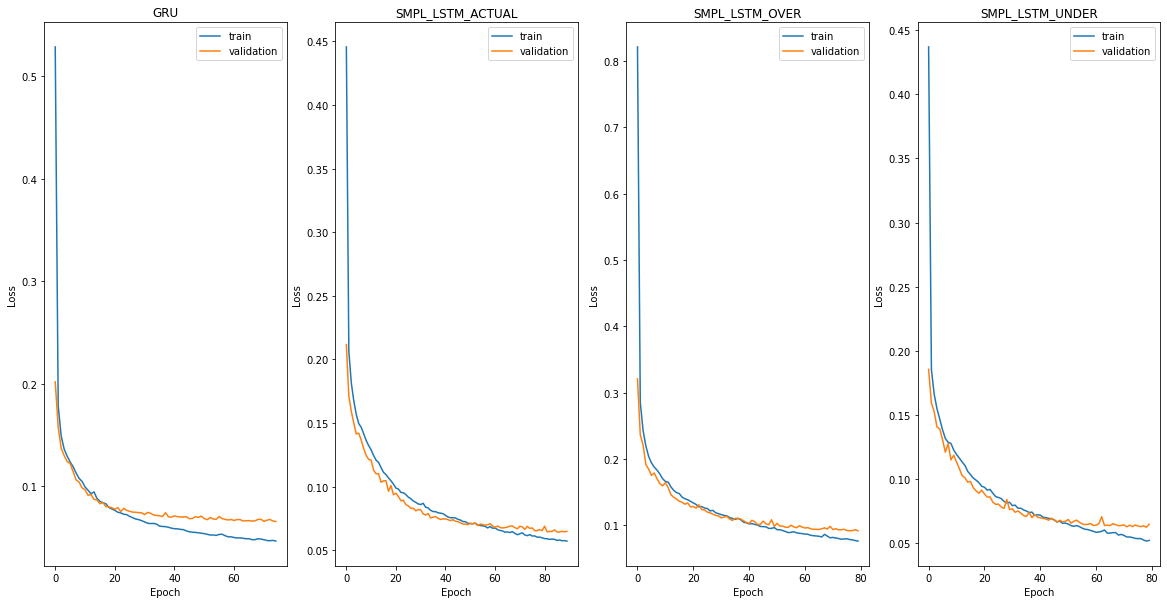

In [ ]:
fig, ax = plt.subplots(1, 4,  figsize = (20, 10))

ax[0].plot(history_gru.history['loss'])
ax[0].plot(history_gru.history['val_loss'])

ax[1].plot(history_smpl_lstm_actual.history['loss'])
ax[1].plot(history_smpl_lstm_actual.history['val_loss'])

ax[2].plot(history_smpl_lstm_over.history['loss'])
ax[2].plot(history_smpl_lstm_over.history['val_loss'])

ax[3].plot(history_smpl_lstm_under.history['loss'])
ax[3].plot(history_smpl_lstm_under.history['val_loss'])

ax[0].set_title('GRU')
ax[1].set_title('SMPL_LSTM_ACTUAL')
ax[2].set_title('SMPL_LSTM_OVER')
ax[3].set_title('SMPL_LSTM_UNDER')

ax[0].legend(['train', 'validation'], loc = 'upper right')
ax[1].legend(['train', 'validation'], loc = 'upper right')
ax[2].legend(['train', 'validation'], loc = 'upper right')
ax[3].legend(['train', 'validation'], loc = 'upper right')

ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[2].set_ylabel('Loss')
ax[2].set_xlabel('Epoch')
ax[3].set_ylabel('Loss')
ax[3].set_xlabel('Epoch')


# Inference and Submission

In [ ]:
public_df = test.query("seq_length == 107").copy()
private_df = test.query("seq_length == 130").copy()

public_inputs = preprocess_inputs(public_df)
private_inputs = preprocess_inputs(private_df )

print ("Test data prepared!")

Test data prepared!


In [ ]:
cols=['sequence', 'structure', 'predicted_loop_type']
np.transpose(
        np.array(
            test[cols]
            .applymap(lambda seq: [token2int[x] for x in seq])
            .values
            .tolist()
        ),
        (0, 2, 1)
    )

ValueError: axes don't match array

**Predict twice, one for the public leaderboard, the other for the private leaderboard:**

In [ ]:
#build all models
gru_short = build_model(gru=True, seq_len=107, pred_len=107)
gru_long = build_model(gru=True, seq_len=130, pred_len=130)
lstm_short_actual = lstm_model(seq_len = 107,output_dim = 100,dropout = 0.5, pred_len = 107)
lstm_long_actual = lstm_model(seq_len = 130,output_dim = 100,dropout = 0.5, pred_len = 130)
lstm_short_over = lstm_model(seq_len = 107,output_dim = 100,dropout = 0.5, pred_len = 107)
lstm_long_over = lstm_model(seq_len = 130,output_dim = 100,dropout = 0.5, pred_len = 130)
lstm_short_under = lstm_model(seq_len = 107,output_dim = 100,dropout = 0.5, pred_len = 107)
lstm_long_under = lstm_model(seq_len = 130,output_dim = 100,dropout = 0.5, pred_len = 130)

#load pre-trained model weights
gru_short.load_weights('model_gru.h5')
gru_long.load_weights('model_gru.h5')
lstm_short_actual.load_weights('model_smpl_lstm_actual.h5')
lstm_long_actual.load_weights('model_smpl_lstm_actual.h5')
lstm_short_over.load_weights('model_smpl_lstm_over.h5')
lstm_long_over.load_weights('model_smpl_lstm_over.h5')
lstm_short_under.load_weights('model_smpl_lstm_under.h5')
lstm_long_under.load_weights('model_smpl_lstm_under.h5')

print ("models built and trained")

models built and trained


This code segment is building and loading the pre-trained weights for eight different models used in a machine learning task. The models are a combination of GRU and LSTM architectures, with different sequence lengths and prediction lengths. The purpose of these models is to predict the prices of a particular asset based on historical price data.

The eight models are:

1. `gru_short`: a GRU-based model with a sequence length of 107 and a prediction length of 107.
2. `gru_long`: a GRU-based model with a sequence length of 130 and a prediction length of 130.
3. `lstm_short_actual`: an LSTM-based model with a sequence length of 107, a prediction length of 107, and actual data.
4. `lstm_long_actual`: an LSTM-based model with a sequence length of 130, a prediction length of 130, and actual data.
5. `lstm_short_over`: an LSTM-based model with a sequence length of 107, a prediction length of 107, and overfitting data.
6. `lstm_long_over`: an LSTM-based model with a sequence length of 130, a prediction length of 130, and overfitting data.
7. `lstm_short_under`: an LSTM-based model with a sequence length of 107, a prediction length of 107, and underfitting data.
8. `lstm_long_under`: an LSTM-based model with a sequence length of 130, a prediction length of 130, and underfitting data.

After building the models, the pre-trained weights for each model are loaded from their respective checkpoint files. The print statement at the end of the code segment confirms that the models have been built and trained.

In [ ]:
#and predict
gru_public_preds = gru_short.predict(public_inputs)
gru_private_preds = gru_long.predict(private_inputs)
lstm_public_actual_preds = lstm_short_actual.predict(public_inputs)
lstm_private_actual_preds = lstm_long_actual.predict(private_inputs)
lstm_public_over_preds = lstm_short_over.predict(public_inputs)
lstm_private_over_preds = lstm_long_over.predict(private_inputs)
lstm_public_under_preds = lstm_short_under.predict(public_inputs)
lstm_private_under_preds = lstm_long_under.predict(private_inputs)

**Now we just need to change the shape of each sample to the long format:**

In [ ]:
preds_gru = []

for df, preds in [(public_df, gru_public_preds), (private_df, gru_private_preds)]:
    for i, uid in enumerate(df.id):
        single_pred = preds[i]

        single_df = pd.DataFrame(single_pred, columns=target_cols_actual)
        single_df['id_seqpos'] = [f'{uid}_{x}' for x in range(single_df.shape[0])]

        preds_gru.append(single_df)

preds_gru_df = pd.concat(preds_gru)
preds_gru_df.head()

,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C,id_seqpos
0,0.660071,0.607149,1.988912,0.578402,0.698077,id_00073f8be_0
1,2.134140,2.832841,3.835249,2.868127,2.570489,id_00073f8be_1
2,1.331981,0.611766,0.722372,0.830197,0.873406,id_00073f8be_2
3,1.262206,1.044615,1.233786,1.566160,1.651897,id_00073f8be_3
4,0.838457,0.517449,0.701548,0.913583,0.974706,id_00073f8be_4


**Now we do the same for the LSTM model so we can blend their predictions:**

In [ ]:
preds_lstm_actual = []

for df, preds in [(public_df, lstm_public_actual_preds), (private_df, lstm_private_actual_preds)]:
    for i, uid in enumerate(df.id):
        single_pred = preds[i]

        single_df = pd.DataFrame(single_pred, columns=target_cols_actual)
        single_df['id_seqpos'] = [f'{uid}_{x}' for x in range(single_df.shape[0])]

        preds_lstm_actual.append(single_df)

preds_lstm_actual_df = pd.concat(preds_lstm_actual)
preds_lstm_actual_df.head()

,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C,id_seqpos
0,0.686361,0.750660,1.932345,0.648361,0.779083,id_00073f8be_0
1,2.028031,3.043442,4.064053,3.147829,2.671132,id_00073f8be_1
2,1.324224,0.625590,0.748306,0.716241,0.787987,id_00073f8be_2
3,1.220480,1.141737,1.232030,1.573864,1.545292,id_00073f8be_3
4,0.830357,0.631680,0.620884,0.804762,0.862158,id_00073f8be_4


In [ ]:
# overpredicting
preds_lstm_over = []

for df, preds in [(public_df, lstm_public_over_preds), (private_df, lstm_private_over_preds)]:
    for i, uid in enumerate(df.id):
        single_pred = preds[i]

        single_df = pd.DataFrame(single_pred, columns=target_cols_over)
        single_df['id_seqpos'] = [f'{uid}_{x}' for x in range(single_df.shape[0])]

        preds_lstm_over.append(single_df)

preds_lstm_over_df = pd.concat(preds_lstm_over)
preds_lstm_over_df.head()

,reactivity_over,deg_Mg_pH10_over,deg_pH10_over,deg_Mg_50C_over,deg_50C_over,id_seqpos
0,1.042678,1.024409,2.116910,0.871608,1.023929,id_00073f8be_0
1,3.028073,3.944280,4.954854,3.760402,3.309914,id_00073f8be_1
2,1.471270,0.737479,0.899208,0.731312,0.957566,id_00073f8be_2
3,1.461824,1.422878,1.618409,1.766843,1.776807,id_00073f8be_3
4,0.997847,0.889768,1.022648,1.032568,1.143623,id_00073f8be_4


In [ ]:
# Underpredicting
preds_lstm_under = []

for df, preds in [(public_df, lstm_public_under_preds), (private_df, lstm_private_under_preds)]:
    for i, uid in enumerate(df.id):
        single_pred = preds[i]

        single_df = pd.DataFrame(single_pred, columns=target_cols_under)
        single_df['id_seqpos'] = [f'{uid}_{x}' for x in range(single_df.shape[0])]

        preds_lstm_under.append(single_df)

preds_lstm_under_df = pd.concat(preds_lstm_under)
preds_lstm_under_df.head()

,reactivity_under,deg_Mg_pH10_under,deg_pH10_under,deg_Mg_50C_under,deg_50C_under,id_seqpos
0,0.454122,0.431645,1.664176,0.414742,0.498714,id_00073f8be_0
1,1.593761,2.792307,3.568632,2.802125,2.289668,id_00073f8be_1
2,1.020973,0.400110,0.507811,0.533069,0.562263,id_00073f8be_2
3,0.978592,0.907282,0.970635,1.314391,1.274081,id_00073f8be_3
4,0.672317,0.450749,0.475850,0.675210,0.670872,id_00073f8be_4


**And now we blend:**

In [ ]:
lstm_weight_actual = 0.65
lstm_weight_over = 0
lstm_weight_under = 0
gru_weight = 0.35
blend_preds_df = pd.DataFrame()
blend_preds_df['id_seqpos'] = preds_gru_df['id_seqpos']

blend_preds_df['reactivity'] = gru_weight*preds_gru_df['reactivity'] + lstm_weight_over*preds_lstm_over_df['reactivity_over']+lstm_weight_under*preds_lstm_under_df['reactivity_under'] +lstm_weight_actual*preds_lstm_actual_df['reactivity']

blend_preds_df['deg_Mg_pH10'] = gru_weight*preds_gru_df['deg_Mg_pH10'] + lstm_weight_over*preds_lstm_over_df['deg_Mg_pH10_over']+lstm_weight_under*preds_lstm_under_df['deg_Mg_pH10_under'] + lstm_weight_actual*preds_lstm_actual_df['deg_Mg_pH10']
    
blend_preds_df['deg_pH10'] = gru_weight*preds_gru_df['deg_pH10'] + lstm_weight_over*preds_lstm_over_df['deg_pH10_over']+lstm_weight_under*preds_lstm_under_df['deg_pH10_under'] + lstm_weight_actual*preds_lstm_actual_df['deg_pH10']

blend_preds_df['deg_Mg_50C'] = gru_weight*preds_gru_df['deg_Mg_50C'] + lstm_weight_over*preds_lstm_over_df['deg_Mg_50C_over']+lstm_weight_under*preds_lstm_under_df['deg_Mg_50C_under'] + lstm_weight_actual*preds_lstm_actual_df['deg_Mg_50C']

blend_preds_df['deg_50C'] = gru_weight*preds_gru_df['deg_50C'] + lstm_weight_over*preds_lstm_over_df['deg_50C_over']+lstm_weight_under*preds_lstm_under_df['deg_50C_under'] + lstm_weight_actual*preds_lstm_actual_df['deg_50C']

This code blends the predictions from multiple models to create a final prediction. The blend is weighted based on the model's performance on the validation set. 

`lstm_weight_actual`, `lstm_weight_over`, `lstm_weight_under`, and `gru_weight` are the weights assigned to each model. In this code snippet, the `lstm_weight_actual` is set to 0.65, which means that the LSTM model trained on actual data will have a higher weight in the final prediction. The other LSTM models (`lstm_weight_over`, `lstm_weight_under`) have zero weight, and the GRU model (`gru_weight`) has a weight of 0.35. 

`blend_preds_df` is a pandas dataframe that contains the final predictions. The code blends the predictions for each target variable (`reactivity`, `deg_Mg_pH10`, `deg_pH10`, `deg_Mg_50C`, and `deg_50C`) from each model. The blended prediction for each target variable is the weighted average of the predictions from each model. 

For example, to calculate the blended prediction for `reactivity`, the code multiplies the predictions from the GRU model by `gru_weight`, the predictions from the LSTM model trained on actual data by `lstm_weight_actual`, and the predictions from the other LSTM models by zero weight (`lstm_weight_over` and `lstm_weight_under` are both zero). The weighted predictions are then summed, and the result is assigned to `blend_preds_df['reactivity']`. This process is repeated for each target variable.

In [ ]:
submission = sample_sub[['id_seqpos']].merge(blend_preds_df, on=['id_seqpos'])

#sanity check

len(submission)
submission.head()

,id_seqpos,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,id_00073f8be_0,0.677159,0.700431,1.952143,0.623875,0.750731
1,id_00073f8be_1,2.065169,2.969731,3.983972,3.049933,2.635907
2,id_00073f8be_2,1.326939,0.620752,0.739229,0.756126,0.817884
3,id_00073f8be_3,1.235084,1.107744,1.232644,1.571167,1.582604
4,id_00073f8be_4,0.833192,0.591699,0.649116,0.842849,0.901550


In [ ]:
submission.to_csv('submission.csv', index=False)
print('Submission saved')

Submission saved
